In [2]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.ensemble import BaggingClassifier
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [3]:
train_x = pd.read_csv('./bora/train_x.csv', index_col=0, header=None)
train_y = pd.read_csv('./bora/train_y.csv', index_col=0)
test_x = pd.read_csv('./bora/test_x.csv', index_col=0, header=None)
print(train_x.shape, test_x.shape)

(7200, 3072) (4800, 3072)


In [4]:
mappping_type = {'Bird': 0, 'Airplane': 1}
train_y = train_y.replace({"target": mappping_type})

In [5]:
_train_x = train_x.values.reshape(7200,32,32,3)
_test_x = test_x.values.reshape(4800,32,32,3)

In [6]:
x_train, x_val, y_train, y_val = \
        train_test_split(_train_x, train_y, test_size=0.2, random_state=42)

In [7]:
print(x_train.shape, y_train.shape)

(5760, 32, 32, 3) (5760, 1)


In [8]:
train_y['target'].value_counts()

1    3634
0    3566
Name: target, dtype: int64

## CNN Solution

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.constraints import maxnorm
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout 
from keras.utils import np_utils
from keras.optimizers import Adam

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=45,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    shear_range=0.1
#     brightness_range
    )
datagen.fit(x_train)

In [11]:
print(x_train.shape, y_train.shape)

(5760, 32, 32, 3) (5760, 1)


In [12]:
y_cat_train = np.array(np_utils.to_categorical(y_train.target.values, num_classes=2))
y_cat_val = np.array(np_utils.to_categorical(y_val.target.values, num_classes=2))
y_cat_all = np.array(np_utils.to_categorical(train_y.target.values, num_classes=2))


In [14]:
cnn = Sequential()
cnn.add(Conv2D(32, (5, 5), input_shape=(32, 32, 3), padding='same', activation='relu', 
                  kernel_constraint=maxnorm(3)) )
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(32, (5, 5), padding='same', activation='relu', kernel_constraint=maxnorm(3)) )
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_constraint=maxnorm(3)) )
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_constraint=maxnorm(3)) )
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_constraint=maxnorm(3)) )
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_constraint=maxnorm(3)) )
cnn.add(Conv2D(64, (5, 5), padding='valid', activation='relu', kernel_constraint=maxnorm(3)) )
cnn.add(BatchNormalization())
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)) )
cnn.add(Conv2D(32, (3, 3), padding='valid', activation='relu', kernel_constraint=maxnorm(3)) )
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(32, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dense(2, activation='softmax'))

adam = Adam()
cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# print(cnn.summary())

In [137]:
history = cnn.fit_generator(datagen.flow(x_train, y_cat_train, batch_size=250), 
                              steps_per_epoch=100, epochs=30, 
                              shuffle=True)

Epoch 1/30
100/100 [==============================] - 8s 76ms/step - loss: 0.2959 - acc: 0.8743
Epoch 2/30
100/100 [==============================] - 8s 75ms/step - loss: 0.3076 - acc: 0.8669
Epoch 3/30
100/100 [==============================] - 7s 75ms/step - loss: 0.3146 - acc: 0.8645
Epoch 4/30
100/100 [==============================] - 8s 75ms/step - loss: 0.2948 - acc: 0.8780
Epoch 5/30
100/100 [==============================] - 7s 75ms/step - loss: 0.2993 - acc: 0.8761
Epoch 6/30
100/100 [==============================] - 7s 74ms/step - loss: 0.2871 - acc: 0.8781
Epoch 7/30
100/100 [==============================] - 7s 74ms/step - loss: 0.2815 - acc: 0.8822
Epoch 8/30
100/100 [==============================] - 7s 74ms/step - loss: 0.2992 - acc: 0.8755
Epoch 9/30
100/100 [==============================] - 7s 74ms/step - loss: 0.3011 - acc: 0.8733
Epoch 10/30
100/100 [==============================] - 7s 75ms/step - loss: 0.2799 - acc: 0.8849
Epoch 11/30
100/100 [==================

In [138]:
accuracy_score(np.argmax(cnn.predict(x_val),axis=1), np.argmax(y_cat_val, axis=1))

0.8979166666666667

# TEST MODEL

In [18]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [22]:
from keras import regularizers
import keras

weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(32, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [23]:
batch_size = 64
history = model.fit_generator(datagen.flow(_train_x, y_cat_all, batch_size=batch_size), 
                              steps_per_epoch=x_train.shape[0] // batch_size, epochs=150, 
                              shuffle=True, callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/250
90/90 [==============================] - 5s 59ms/step - loss: 0.8049 - acc: 0.7439
Epoch 2/250
90/90 [==============================] - 2s 28ms/step - loss: 0.7003 - acc: 0.7790
Epoch 3/250
90/90 [==============================] - 2s 26ms/step - loss: 0.6511 - acc: 0.8036
Epoch 4/250
90/90 [==============================] - 2s 26ms/step - loss: 0.6131 - acc: 0.8033
Epoch 5/250
90/90 [==============================] - 2s 27ms/step - loss: 0.5819 - acc: 0.8174
Epoch 6/250
90/90 [==============================] - 2s 27ms/step - loss: 0.5639 - acc: 0.8137
Epoch 7/250
90/90 [==============================] - 2s 27ms/step - loss: 0.5270 - acc: 0.8269
Epoch 8/250
90/90 [==============================] - 2s 27ms/step - loss: 0.5271 - acc: 0.8248
Epoch 9/250
90/90 [==============================] - 2s 27ms/step - loss: 0.4876 - acc: 0.8330
Epoch 10/250
90/90 [==============================] - 2s 27ms/step - loss: 0.4707 - acc: 0.8465
Epoch 11/250
90/90 [=============================

90/90 [==============================] - 2s 27ms/step - loss: 0.2094 - acc: 0.9365
Epoch 167/250
90/90 [==============================] - 2s 27ms/step - loss: 0.2151 - acc: 0.9344: 1s - loss: 
Epoch 168/250
90/90 [==============================] - 2s 27ms/step - loss: 0.2115 - acc: 0.9405
Epoch 169/250
90/90 [==============================] - 2s 27ms/step - loss: 0.2094 - acc: 0.9370
Epoch 170/250
90/90 [==============================] - 2s 27ms/step - loss: 0.2078 - acc: 0.9365
Epoch 171/250
90/90 [==============================] - 2s 27ms/step - loss: 0.2139 - acc: 0.9363
Epoch 172/250
90/90 [==============================] - 2s 27ms/step - loss: 0.2056 - acc: 0.9378
Epoch 173/250
90/90 [==============================] - 2s 27ms/step - loss: 0.2169 - acc: 0.9347
Epoch 174/250
90/90 [==============================] - 2s 27ms/step - loss: 0.1974 - acc: 0.9425
Epoch 175/250
90/90 [==============================] - 2s 27ms/step - loss: 0.2202 - acc: 0.9323
Epoch 176/250
90/90 [==========

In [24]:
accuracy_score(np.argmax(model.predict(x_val),axis=1), np.argmax(y_cat_val, axis=1))

0.9722222222222222

In [170]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5') 
 

In [25]:
prediction = model.predict(_test_x)

In [26]:
print(prediction[:10])

[[2.4575619e-03 9.9754250e-01]
 [6.0797322e-01 3.9202675e-01]
 [9.9868304e-01 1.3169284e-03]
 [1.8196836e-01 8.1803161e-01]
 [3.5764121e-02 9.6423584e-01]
 [3.6147574e-03 9.9638522e-01]
 [1.2516640e-03 9.9874830e-01]
 [9.0967995e-01 9.0320021e-02]
 [1.7343678e-04 9.9982661e-01]
 [6.9514210e-03 9.9304855e-01]]


In [27]:
sample = pd.DataFrame(np.array([[i, x.argmax()] for i, x in enumerate(prediction)]), columns=['id', 'target'])

mappping_type_inv = {0: 'Bird', 1: 'Airplane'}
sample = sample.replace({'target': mappping_type_inv})
sample.to_csv('submit.csv', index=False)

# GrayScale

In [40]:
def viz_img(df, i):
    plt.imshow(df.values.reshape(df.shape[0], 32, 32, 3)[i])
    plt.show()
    
    
def viz_img_gray(df, i):
    img = rgb2gray(df)[i]
    plt.imshow(img)
    plt.show()
def rgb2gray(rgb):
    rgb = rgb.values.reshape(rgb.shape[0], 32, 32, 3)
    return np.matmul(rgb, [0.2989, 0.5870, 0.1140])

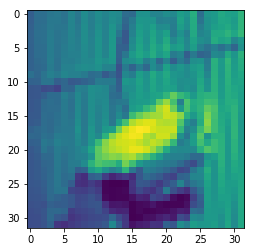

In [41]:
viz_img_gray(train_x, 7)

In [42]:
%%time
train_in_gray = rgb2gray(train_x)

Wall time: 138 ms


In [46]:
print(train_x.shape, train_in_gray.shape)
train_in_gray = train_in_gray.reshape(7200, 1024)

(7200, 3072) (7200, 32, 32)


In [47]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = \
        train_test_split(train_in_gray, train_y, test_size=0.2, random_state=42)


#  END

# SGDClassifier

In [97]:
train_feature_matrix, test_feature_matrix = train_feature_matrix/255, test_feature_matrix/255

In [79]:
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(train_feature_matrix, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [99]:
accuracy_score(clf.predict(test_feature_matrix), test_labels)

0.6097222222222223

In [89]:
%%time
clf = SGDClassifier(loss='log', penalty='l2')
param_grid={
    'max_iter':np.linspace(100, 10000, 10),
    'tol': np.linspace(0.0001, 0.01, 10)
    }
gs = GridSearchCV(clf, param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy') 
gs.fit(train_feature_matrix, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 1min 21s


In [90]:
gs.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=8900.0,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.0089,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [98]:
clf = SGDClassifier(loss='log', penalty='l2')
clf.fit(train_feature_matrix, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

## LogisticRegression

In [102]:
%%time
lr_clf = LogisticRegression(solver='saga')

Wall time: 0 ns


In [103]:
%%time
param_grid={
    'C': np.linspace(0.01, 1, 4), 
    'penalty': ['l1', 'l2']
    }
gs = GridSearchCV(lr_clf, param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy') 
gs.fit(train_feature_matrix, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 46.6 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [104]:
gs.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [142]:
best_lr_clf = LogisticRegression(penalty='l2', C=0.01, solver='saga')

best_lr_clf.fit(train_feature_matrix, train_labels)
accuracy_score(best_lr_clf.predict(test_feature_matrix), test_labels)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7680555555555556

In [210]:
best_lr_clf = LogisticRegression(penalty='l2', C=0.01, solver='saga')

best_lr_clf.fit(train_x, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [211]:
predict_y_lr = best_lr_clf.predict_proba(test_x)

In [132]:
sample = pd.DataFrame(np.array([[i, x.argmax()] for i, x in enumerate(predict_y)]), columns=['id', 'target'])

mappping_type_inv = {0: 'Bird', 1: 'Airplane'}
sample = sample.replace({'target': mappping_type_inv})

In [133]:
sample.head()

,id,target
0,0,Airplane
1,1,Airplane
2,2,Airplane
3,3,Airplane
4,4,Airplane


In [134]:
sample.to_csv('submit.csv', index=False)

In [135]:
ans = pd.read_csv('submit.csv', index_col=0)
print(len(ans))

4800


# KNN

In [6]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
k = list(range(1, 3, 3))
param_grid={
    'n_neighbors': k,
    'weights': ['distance', 'uniform']
    }
gs = GridSearchCV(knn, param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(train_feature_matrix, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Wall time: 52 s


In [7]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='distance')

In [208]:
%%time
best_knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
best_knn.fit(train_x, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Wall time: 2.04 s


In [207]:
accuracy_score(best_knn.predict(test_feature_matrix), test_labels)

0.7631944444444444

In [209]:
predict_y_knn = best_knn.predict_proba(test_x)

# Random forest

In [143]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.special import binom
from IPython.display import Image
from matplotlib import pyplot as plt

from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits as load
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split

%matplotlib inline

In [ ]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = \
        train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [150]:
d3 = DecisionTreeClassifier() # Обычное решающее дерево

print("Decision tree:", cross_val_score(d3,train_feature_matrix, train_labels).mean())

Decision tree: 0.7107648321554599


In [151]:
print("Bagging:", cross_val_score(BaggingClassifier(d3), train_feature_matrix, train_labels).mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:621: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:621: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:621: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Bagging: 0.7824634300509491


In [152]:
f = train_feature_matrix.shape[1]
rnd_d3 = DecisionTreeClassifier(max_features=int(f ** 0.5)) # Решающее дерево с рандомизацией в сплитах

print("Randomized Bagging:", cross_val_score(BaggingClassifier(rnd_d3), train_feature_matrix, train_labels).mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:621: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:621: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:621: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Randomized Bagging: 0.7895821200237986


In [160]:
d3.fit(train_x, train_y)
#

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [177]:
%%time
d3 = DecisionTreeClassifier()
param_grid={
    'criterion':  ['gini', 'entropy'],
    'max_depth':['2', '5','10', 'None']
    }
accuracy = []
# for k, criterion in enumerate(['gini', 'entropy']):
for i, max_depth in enumerate([10, 15, 20, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, criterion="gini")
        clf.fit(train_feature_matrix, train_labels)
        accuracy.append(accuracy_score(clf.predict(test_feature_matrix), test_labels))

Wall time: 2min 5s


In [194]:
%%time
d3 = DecisionTreeClassifier(criterion="gini")
#bag_d3 = BaggingClassifier(ds)
accuracy = []
for i, n_estimators in enumerate([ 1000]):
    for j, max_samples in enumerate([1]):
        bag_d3 = BaggingClassifier(d3, n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples)
        bag_d3.fit(train_feature_matrix, train_labels.values.ravel())
        accuracy.append((i,j,accuracy_score(bag_d3.predict(test_feature_matrix), test_labels.values.ravel())))

Wall time: 22.3 s


In [204]:
accuracy

[(0, 0, 0.5027777777777778), 0.7458333333333333]

In [ ]:
accuracy = []
for i, max_depth in enumerate([2, 5, 10, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        
        clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, criterion="entropy")
        clf.fit(train_feature_matrix, train_labels)
        accuracy.append(accuracy_score(clf.predict(test_feature_matrix), test_labels))

In [ ]:
10 ,5

In [197]:
d3 = DecisionTreeClassifier(criterion="gini")
d3 = BaggingClassifier(d3, n_jobs=-1, n_estimators=1000, max_samples=25)
d3.fit(train_x, train_y.values.ravel())

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=25, n_estimators=1000, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [203]:
d3 = DecisionTreeClassifier(criterion="gini")
d3 = BaggingClassifier(d3, n_jobs=-1, n_estimators=1000, max_samples=25)
d3.fit(test_feature_matrix, test_labels.values.ravel())
accuracy.append(accuracy_score(d3.predict(test_feature_matrix), test_labels))

In [200]:
predict_y_d3 = d3.predict_proba(test_x)

In [202]:
print(predict_y_d3[0])

[0.377 0.623]


In [214]:
prediction = (predict_y_d3 * 0.7458 + predict_y_knn * 0.7632 + predict_y_lr * 0.768) / (0.7458 + 0.7632 + 0.768)

In [215]:
print(prediction[0])

[0.15372921 0.84627079]


# ANSVER

In [216]:
#predict_y = best_lr_clf.predict_proba(test_x)

sample = pd.DataFrame(np.array([[i, x.argmax()] for i, x in enumerate(prediction)]), columns=['id', 'target'])

mappping_type_inv = {0: 'Bird', 1: 'Airplane'}
sample = sample.replace({'target': mappping_type_inv})
sample.to_csv('submit.csv', index=False)